# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [17]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, exposure, morphology, io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import warnings

In [18]:
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0
DEBUG = True
if not DEBUG:
    warnings.filterwarnings('ignore')

In [19]:
# Metody pomocnicze
def segment():
    return None

def invert_nparr(nparr):
    ARR_MAX = nparr.max()
    ARR_MIN = nparr.min()
    for i in range(nparr.shape[0]):
        for j in range(nparr.shape[1]):
            if nparr[i][j] == ARR_MAX:
                nparr[i][j] = ARR_MIN
            else:
                nparr[i][j] = ARR_MAX
    return nparr

# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False, cmap="gray"):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

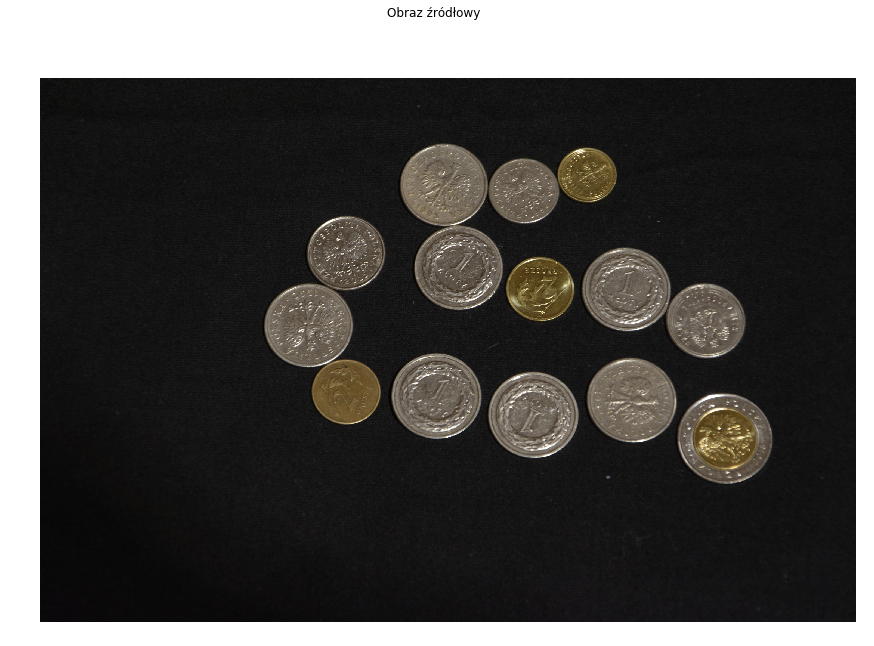

C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


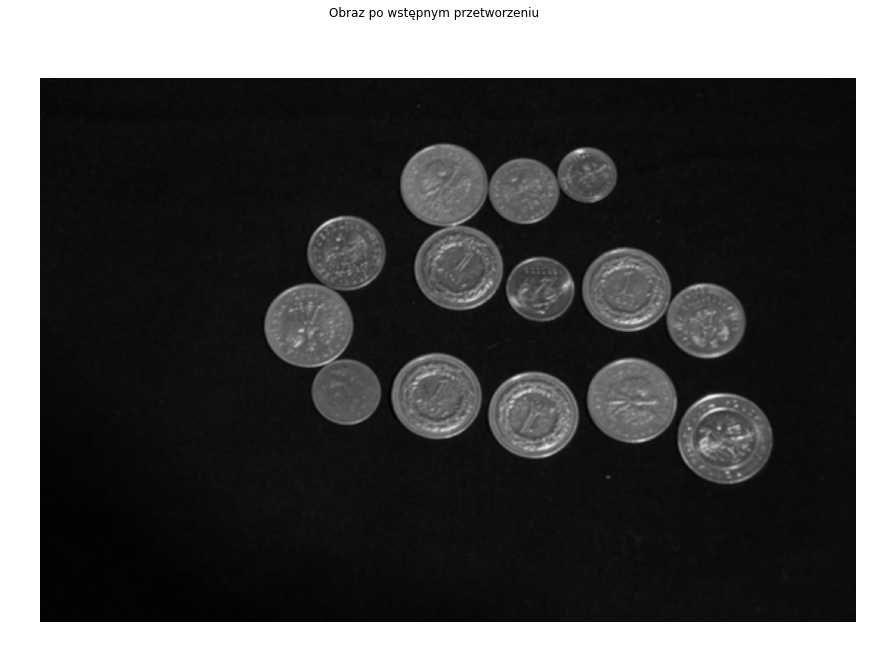

In [20]:
sourceimg = io.imread("source.jpg")

showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))
processedimg = cv2.blur(processedimg, (11,11))
# processedimg = exposure.adjust_gamma(processedimg, gamma=0.6)

# processedimg = cv2.equalizeHist(processedimg)

bwblurredimg = processedimg.copy()

showimg(bwblurredimg, title="Obraz po wstępnym przetworzeniu")

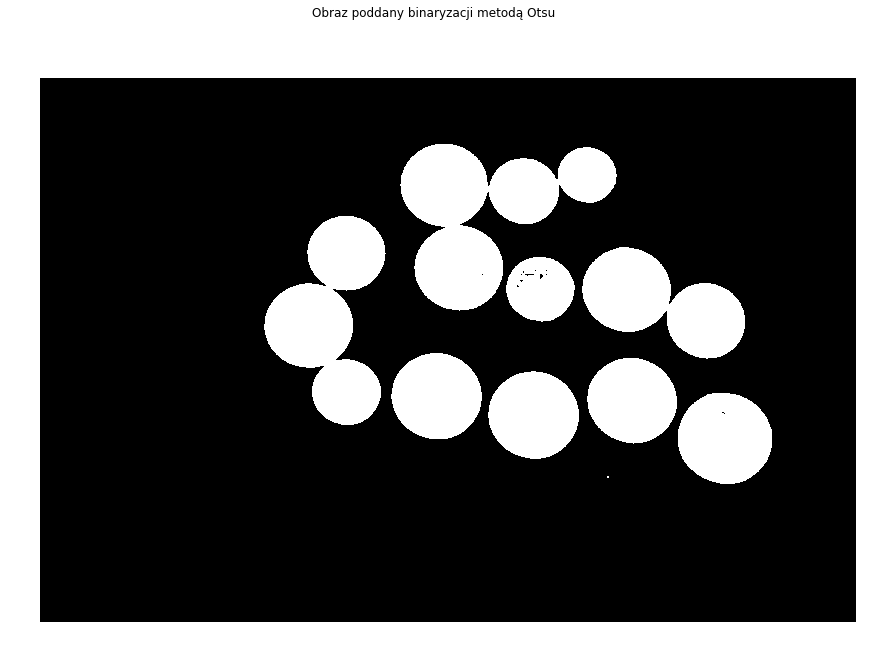

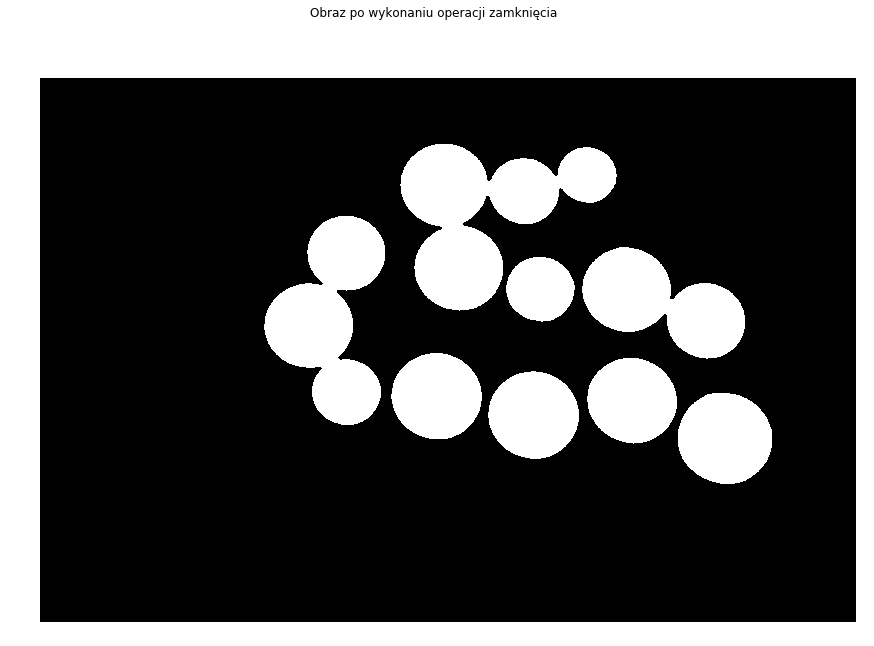

In [21]:
th = 128
th, bim = cv2.threshold(bwblurredimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu")

morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=2)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_OPEN, kernel=morphKernel, iterations=2)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=2)

binaryimg = processedimg.copy()

showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


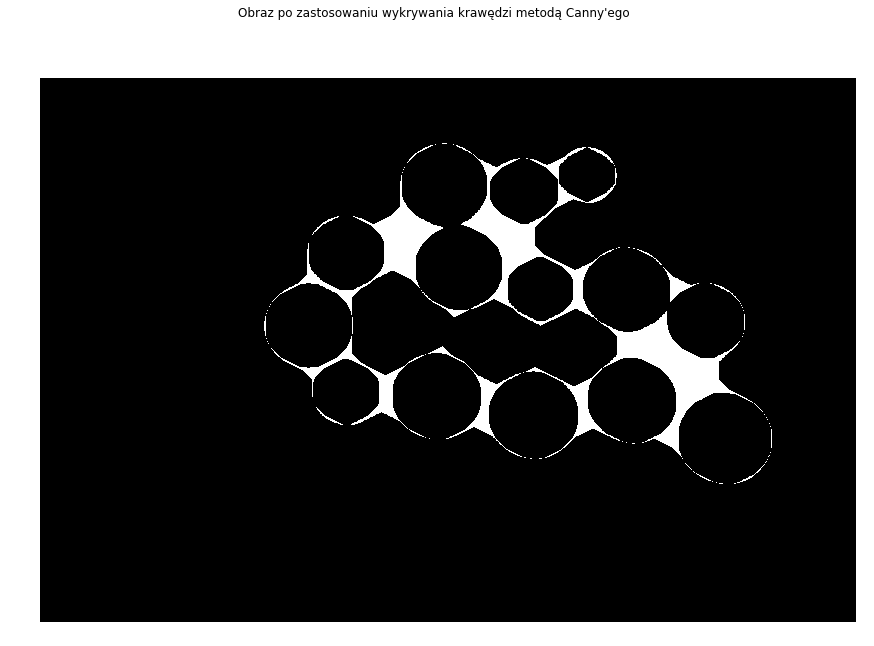

In [22]:
processedimg = cv2.GaussianBlur(processedimg, (5,5), 0)
edgeimg = cv2.Canny(processedimg, 50, 120)
edgeimg = cv2.morphologyEx(edgeimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=33)
showimg(edgeimg, title="Obraz po zastosowaniu wykrywania krawędzi metodą Canny'ego")

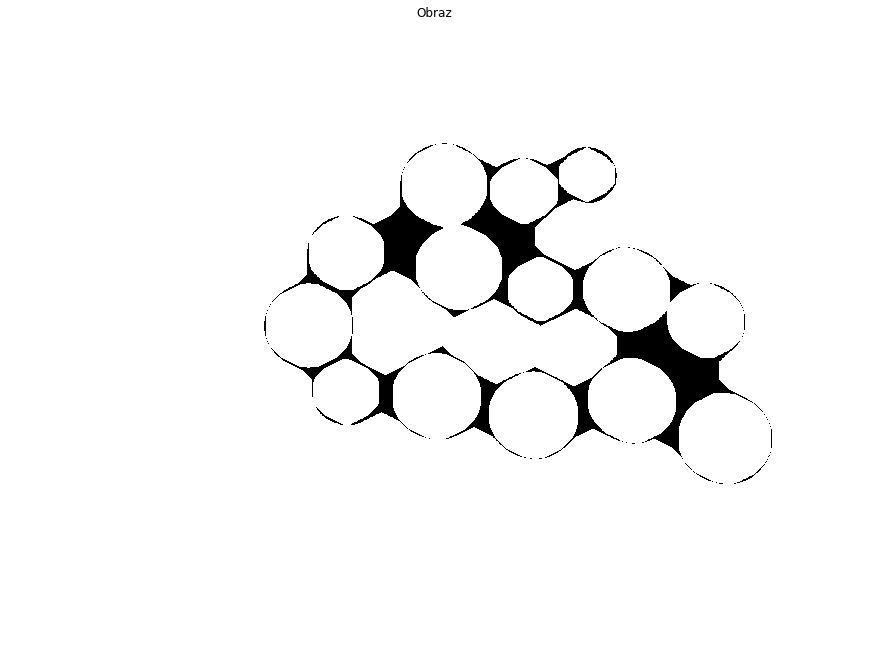

In [23]:
invedgeimg = invert_nparr(edgeimg.copy())
showimg(invedgeimg)

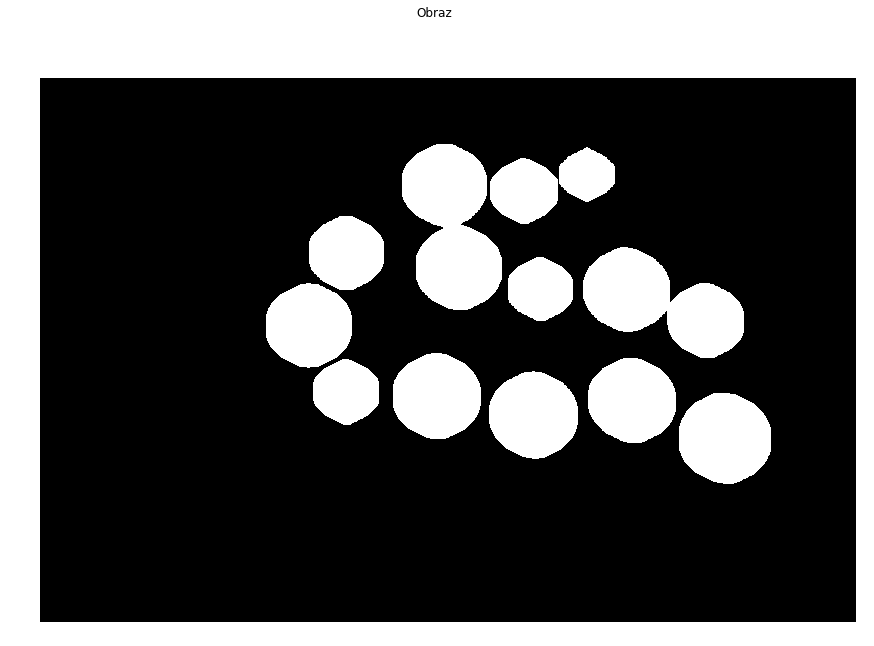

In [24]:
modifiedimg = np.bitwise_and(binaryimg, invedgeimg)
showimg(modifiedimg)